##**Introduction**

GetIdea is a project which aims to provide users with innovative solutions by combining products from various fields based on user input. The application ***will suggest unique product ideas*** derived from the selected products, fostering creativity and innovation.

## **System Design**
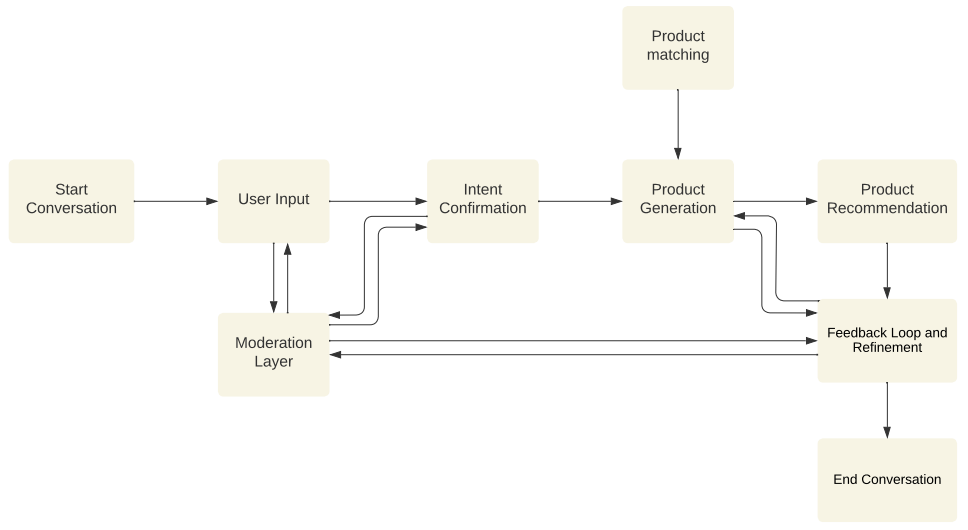


# **Implementation**

##**Part 1:**
   Install OpenAi.

* Install OpenAi.
* Import required libraries.
* Load the Dataset.
* Return the Dataset as a json object.

In [1]:
!pip install -U -q openai tenacity

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.7/320.7 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.9 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import csv
import requests

# Function to read the CSV file from a URL and convert it to a list of dictionaries
def read_csv_from_url(url):
    response = requests.get(url)
    response.raise_for_status()  # Check for request errors
    csv_content = response.content.decode('utf-8').splitlines()
    csv_reader = csv.DictReader(csv_content)
    dataset = [row for row in csv_reader]
    return dataset             # this returns a json object

In [4]:
# URL to the CSV file
file_url = 'https://raw.githubusercontent.com/Unnathi-Gowda54/GetIdea/main/products.csv'

# Read the dataset from the CSV file
Products = read_csv_from_url(file_url)

In [5]:
# Importing the required libraries
import os, json, ast
import openai
from tenacity import retry, wait_random_exponential, stop_after_attempt

In [6]:
openai.api_key = open("/content/drive/MyDrive/OpenAI_API_Key.txt", "r").read().strip()
os.environ['OpenAI_API_Key'] = openai.api_key

##**Part 2**:
Implementation of the different stages.



###**Stage 1**
This stage includes following phases:


1. Start conversation.
2. User Input.
3. Moderation Check.
4. Intent Confirmation.

The functions implemented in this stage are:
- initialize_conversation()
- get_chat_completions()
- moderation_check()
- intent_confirmation_layer()
- dictionary_present()

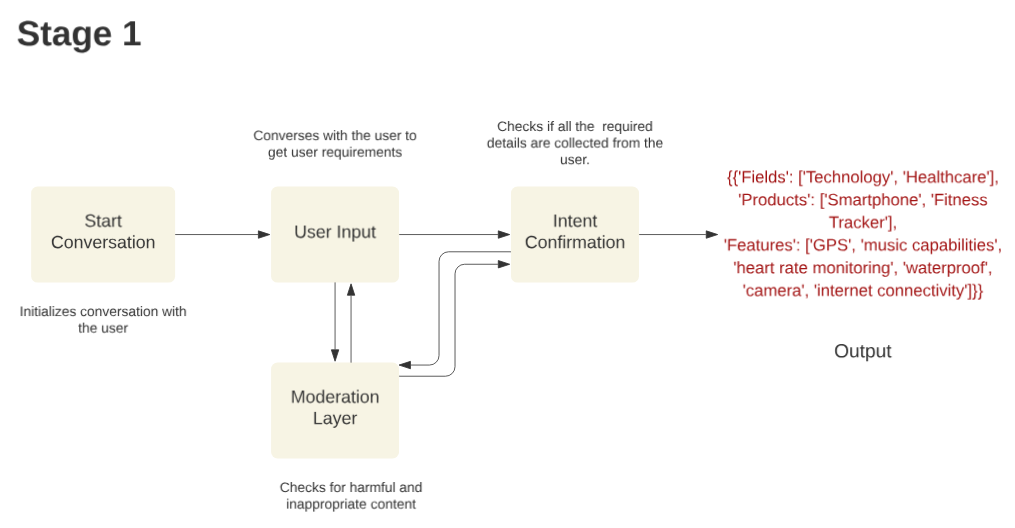

####**initialize_conversation():**
This function initializes a conversation that helps users find innovative product combinations by asking questions and understanding their needs. It guides the assistant to fill a user profile dictionary with values for 'Fields', 'Products', and 'Features'.

In [7]:
#initilize conversation
def initialize_conversation():
    '''
    Returns a list [{"role": "system", "content": system_message}]
    '''

    example_user_dict = {
        'Fields': ['Healthcare', 'Technology'],
        'Products': ['smartwatch', 'fitness tracker'],
        'Features': ['GPS', 'music capabilities', 'heart rate monitoring', 'waterproof']
    }
    delimiter = "####"

    system_message = f"""
    You are an intelligent assistant, who aims to provide users with innovative solutions by combining products from various fields based on user input. Your goal is to find the best combination of products for a user.
    You need to ask relevant questions and understand the user profile by analyzing the user's responses.
    Your final objective is to fill the values for the different keys ('Fields', 'Products', 'Features') in the python dictionary and be confident of the values.
    Go through this dataset before filling in the fields for the products mentioned by the user in case if the user misses mentioning the fields {Products}
    These key value pairs define the user's profile.
    The python dictionary looks like this:
    {{'Fields': ['value1', 'value2'], 'Products': ['product1', 'product2'], 'Features': ['feature1', 'feature2', 'feature3', 'feature4']}}

    Go through the dataset before filling the fields if the use
    {delimiter}
    Here are some instructions around the values for the different keys. If you do not follow this, you'll be heavily penalized:
    - The values for all keys should be clearly identified based on the user's requirements.
    - Do not randomly assign values to any of the keys.
    - The values need to be inferred from the user's response.
    {delimiter}

    To fill the dictionary, you need to have the following chain of thoughts:
    Follow the chain-of-thoughts below and only output the final updated python dictionary for the keys as described in the provided example {example_user_dict}. \n
    {delimiter}
    Thought 1: Ask a question to understand the user's profile and requirements. \n
    If their primary use for the product is unclear, ask follow-up questions to understand their needs.
    You are trying to fill the values of all the keys {{'Fields', 'Products', 'Features'}} in the python dictionary by understanding the user requirements.
    Identify the keys for which you can fill the values confidently using the understanding. \n
    Remember the instructions around the values for the different keys.
    If the necessary information has been extracted, only then proceed to the next step. \n
    Otherwise, rephrase the question to capture their profile clearly. \n

    {delimiter}
    Thought 2: Now, you are trying to fill the values for the rest of the keys which you couldn't in the previous step.
    Remember the instructions around the values for the different keys.
    Ask questions you might have for all the keys to strengthen your understanding of the user's profile.
    If yes, move to the next Thought. If no, ask questions on the keys whose values you are unsure of. \n
    It is a good practice to ask questions with sound logic as opposed to directly citing the key you want to understand value for.
    {delimiter}

    {delimiter}
    Thought 3: Check if you have correctly updated the values for the different keys in the python dictionary.
    If you are not confident about any of the values, ask clarifying questions.
    {delimiter}

    {delimiter}
    Thought 4: If the user is not sure about what products to combine from what fields, you traverse through this dataset: \n {Products} \n.
    You will suggest the fields and products based on this dataset.
    {delimiter}

    {delimiter}
    Thought 5: Do not mistake a product in dataset with another, Analyze product column, field , features and description.
    Only after analyzing in the best possible way, suggest the products.

    {delimiter}
    Here is one of sample conversation between the user and assistant when user knows some details:
    User: "Hello! I'm Rita, an entrepreneur"
    Assistant: "Hello Rita! How can I help you?".
    User: " I'm looking for a product that can integrate Healthcare and Technology to start a new business"
    Assistant: "Great! What products do you have in mind?"
    User: "I want a gadget that combines a smartwatch and a fitness tracker with GPS and music capabilities."
    Assistant: "Do you want the gadget to have additional features like heart rate monitoring or waterproof capabilities?"
    User: "Yes, That would be good!"
    Assistant: "So, you want a device that combines a smartwatch, a fitness tracker, GPS, music capabilities, heart rate monitoring, and is waterproof. Is that correct?"
    User: "Yes, that's correct."
    Assistant: "{example_user_dict}"
    {delimiter}

    {delimiter}
    Here is another sample conversation between the user and assistant when user doesn't know much detail:
    User: "Hello! I'm Rita, an entrepreneur"
    Assistant: "Hello Rita! How can I help you?"
    User: "I'm looking for a product that can integrate Healthcare and Technology to start a new business"
    Assistant: "Great! What products do you have in mind?"
    User: "I'm not really sure. I need something innovative."
    Assistant: "No problem! We can explore a few options. For example, we could look at combining features from products like smartwatches and fitness trackers. Do you think a device that monitors health metrics, like heart rate and sleep patterns, would be useful?"
    User: "Yes, that sounds interesting."
    Assistant: "Alright, we can also consider adding features like GPS for location tracking and music capabilities for entertainment. How does that sound?"
    User: "That sounds good. Can it also be waterproof?"
    Assistant: "Absolutely! So, to summarize, you're looking for a device that combines a smartwatch and a fitness tracker, with health monitoring features, GPS, music capabilities, and is waterproof. Does that cover everything?"
    User: "Yes, that's perfect."
    Assistant: "{example_user_dict}"
    {delimiter}

    The user can either enter the serial number or the product name.

    Start with a short welcome message about GetIdea like you are welcoming the user to GetIdea and
    encourage the user to share their requirements.
    """
    conversation = [{"role": "system", "content": system_message}]
    return conversation


####**get_chat_completions():**
This function generates responses from the OpenAI Chat API using the GPT-3.5-turbo model, with an option to receive the output in JSON format.

In [8]:
# A Chat Completions API call
# Retry up to 6 times with exponential backoff, starting at 1 second and maxing out at 20 seconds delay
@retry(wait=wait_random_exponential(min=1, max=20), stop=stop_after_attempt(6))
def get_chat_completions(input, json_format = False):
    MODEL = 'gpt-3.5-turbo'

    system_message_json_output = """<<. Return output in JSON format to the key output.>>"""

    # If the output is required to be in JSON format
    if json_format == True:
        # Append the input prompt to include JSON response as specified by OpenAI
        input[0]['content'] += system_message_json_output

        # JSON return type specified
        chat_completion_json = openai.chat.completions.create(
            model = MODEL,
            messages = input,
            response_format = { "type": "json_object"},
            seed = 1234)

        output = json.loads(chat_completion_json.choices[0].message.content)

    # No JSON return type specified
    else:
        chat_completion = openai.chat.completions.create(
            model = MODEL,
            messages = input,
            temperature = 0,
            seed = 2345)

        output = chat_completion.choices[0].message.content

    return output

####**moderation_check():**
This function takes a user's input and sends it to the OpenAI API for moderation. It checks if the input is flagged for any issues. Based on the API's response, the function returns either "Flagged" or "Not Flagged".








In [9]:
# A function called moderation_check that takes user_input as a parameter.

def moderation_check(user_input):
    # Call the OpenAI API to perform moderation on the user's input.
    response = openai.moderations.create(input=user_input)

    # Extract the moderation result from the API response.
    moderation_output = response.results[0].flagged
    # Check if the input was flagged by the moderation system.
    if response.results[0].flagged == True:
        # If flagged, return "Flagged"
        return "Flagged"
    else:
        # If not flagged, return "Not Flagged"
        return "Not Flagged"

####**intent_confirmation_layer():**
This function evaluates a given input text to ensure it contains specific keys ('Fields', 'Products', 'Features') and checks if these keys have values filled correctly. It generates a JSON response with 'Yes' if all values are correctly filled, otherwise 'No' along with the reason. The function uses OpenAI's GPT-3.5 model to perform this evaluation.

In [10]:
def intent_confirmation_layer(response_assistant):

    delimiter = "####"

    prompt = f"""
    You are a senior evaluator who has an eye for detail.The input text will contain a user requirement captured through 3 keys.
    You are provided an input. You need to evaluate if the input text has the following keys:
    {{
    'Fields': ['field1','field2',....],
    'Products': ['product1','product2',....],
    'Features':['feature1','feature2',.....],
    }}
    Next you need to evaluate if the keys have the the values filled correctly.
    Only output a one-word string in JSON format at the key 'result' - Yes/No.
    Thought 1 - Output a string 'Yes' if the values are correctly filled for all keys, otherwise output 'No'.
    Thought 2 - If the answer is No, mention the reason in the key 'reason'.
    THought 3 - Think carefully before the answering.
    """

    messages=[{"role": "system", "content":prompt },
              {"role": "user", "content":f"""Here is the input: {response_assistant}""" }]

    response = openai.chat.completions.create(
                                    model="gpt-3.5-turbo",
                                    messages = messages,
                                    response_format={ "type": "json_object" },
                                    seed = 1234
                                    # n = 5
                                    )

    json_output = json.loads(response.choices[0].message.content)

    return json_output

####**dictionary_present():**
This function takes a string input, checks if it contains a Python dictionary with specific keys ('Fields', 'Products', 'Features'), and extracts the dictionary in JSON format if present. It ensures that the dictionary's keys and values match a predefined format.

In [11]:
import json

def dictionary_present(response):
    delimiter = "####"

    user_requirements = {
        'Fields': ["Technology", "Healthcare"],
        'Products': ["Smartphone", "Fitness Tracker"],
        'Features': ["GPS", "music capabilities", "heart rate monitoring", "waterproof", "camera", "internet connectivity"]
    }

    prompt = f"""You are a python expert. You are provided an input.
            You have to check if there is a python dictionary present in the string.
            It will have the following format {user_requirements}.
            Your task is to just extract the relevant values from the input and return only the python dictionary in JSON format.
            The output should match the format as {user_requirements}.

            {delimiter}
            Make sure that the values for 'Fields', 'Products', and 'Features' are also present in the user input. ###
            The output should contain the exact keys and values as present in the input.
            Ensure the keys and values are in the given format:
            {{
            'Fields': ['value1', 'value2', ...],
            'Products': ['value1', 'value2', ...],
            'Features': ['value1', 'value2', ...]
            }}
            Here are some sample input output pairs for better understanding:
            {delimiter}
            input 1: - Fields: ['Technology', 'Healthcare'] - Products: ['Smartphone', 'Fitness Tracker'] - Features: ['GPS', 'music capabilities', 'heart rate monitoring', 'waterproof', 'camera', 'internet connectivity']
            output 1: {{'Fields': ['Technology', 'Healthcare'], 'Products': ['Smartphone', 'Fitness Tracker'], 'Features': ['GPS', 'music capabilities', 'heart rate monitoring', 'waterproof', 'camera', 'internet connectivity']}}

            input 2: {{'Fields': ['Technology'], 'Products': ['Smartphone'], 'Features': ['camera', 'internet connectivity']}}
            output 2: {{'Fields': ['Technology'], 'Products': ['Smartphone'], 'Features': ['camera', 'internet connectivity']}}

            input 3: Here are your preferences 'Fields': ['Healthcare'], 'Products': ['Fitness Tracker'], 'Features': ['heart rate monitoring', 'waterproof']
            output 3: {{'Fields': ['Healthcare'], 'Products': ['Fitness Tracker'], 'Features': ['heart rate monitoring', 'waterproof']}}
            {delimiter}
            """
    # Simulating the behavior of the chat completions call
    messages = [{"role": "system", "content": prompt},
                {"role": "user", "content": f"""Here is the user input: {response}"""}]

    confirmation = get_chat_completions(messages, json_format=True)

    return confirmation



###**Stage 2**
This stage includes following phases:

1. Product Matching
2. Product Generation

The functions implemented in this stage are:
- match_requirements_with_dataset()
- generate_product_concept()

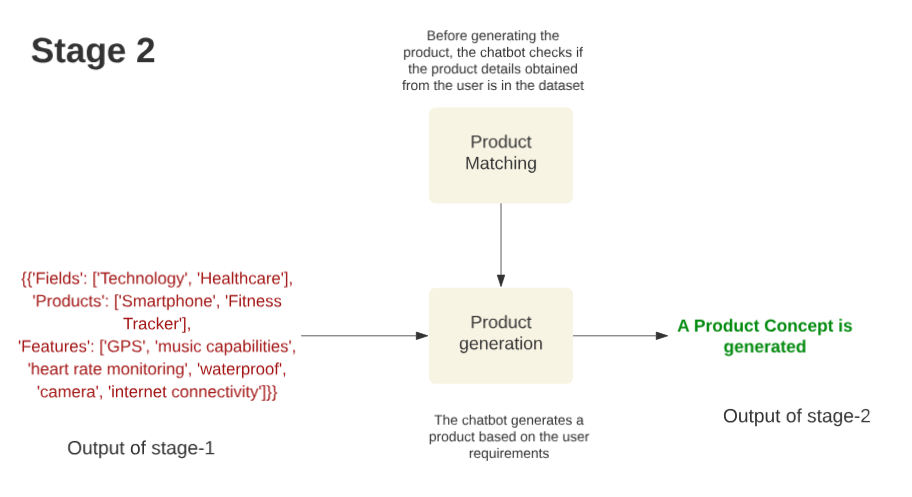


####**match_requirements_with_dataset():**
This function compares a user's specified product requirements with a given dataset. It identifies and lists products that match the dataset, appends relevant features and descriptions of matched products.

In [12]:
def match_requirements_with_dataset(user_requirements, dataset):
    matched_products = []
    matched_features = user_requirements['Features']
    descriptions = []
    unmatched_products = []

    for product in user_requirements.get('Products', []):
        matched = False
        for data in dataset:
            if product.lower() == data['name'].lower():
                matched_products.append(product)
                descriptions.append(data['description'])
                matched_features.extend(data['features'].split(';'))
                matched = True
                break
        if not matched:
            unmatched_products.append(product)


    return matched_products, matched_features, descriptions, unmatched_products

# # Example usage
# user_requirements = {
#          'Fields': ['Technology', 'Home Appliances'],
#          'Products': ['Smartphone', 'Washing Machine','Smart Boll'],
#          'Features': ['touchscreen', 'energy efficient']}

# matched_products, matched_features, descriptions, unmatched_products = match_requirements_with_dataset(user_requirements, Products)

# print(matched_products)
# print(matched_features)
# print(descriptions)
# print(unmatched_products)

####**generate_product_concept():**
This function generates a new product concept by matching user requirements with available data from a dataset. It prepares a prompt for an AI model to create a detailed product description, name, and key features based on the matched information. If some user-requested products are not found in the dataset, it includes an appropriate apology message in the output.

There are three cases here:
1. **All the products are matched:**
      The products are matched with the dataset. If there are matched products in the user requirements dictionary, then, the assistant generates a product concept.
2. **Only some of the products are matched:**
      When there are some unmatched products, the assistant outputs a apology message for the unavailable product infomation and generates a product concept for matched products.
3. **No matched products:**
     When there are no matched products, the assistant outputs an apology message.


In [13]:
def generate_product_concept(user_requirements, dataset):
    """
    Matches user requirements with available data and generates a new product concept.

    Parameters:
    user_requirements (dict): A dictionary containing 'Fields', 'Products', and 'Features'.
    dataset (list): A list of dictionaries representing the dataset.

    Returns:
    dict: A dictionary containing the product concept with 'ConceptName', 'Description', and 'Features'.
    """

    # Match requirements with the dataset
    matched_products, matched_features, descriptions, unmatched_products = match_requirements_with_dataset(user_requirements, dataset)

    # print(matched_products, matched_features, descriptions, unmatched_products)

    if unmatched_products and not matched_products:
        apology = f"My apologies! I do not have access to the information about product(s) {', '.join(unmatched_products)} you are describing. Would you like to start the process with some other products?"

    elif unmatched_products and matched_products:
        apology = f"My apologies! I do not have access to the information about product(s) {', '.join(unmatched_products)} you are describing. I'll generate a product by combining other products."
    else:
        apology = ""

    # Prepare the prompt for the generative AI model
    prompt = f"""
    You are an expert product designer. Based on the following user requirements and matched products,
    create a new product concept that combines the features of the given products, ensuring compatibility
    and optimizing design to meet user needs.

    ###
    Thought 1: Preserve the basic products combined to generate new product.
    ###

    ###
    Thought 2: Do to not repeat the key features.
    ###

    ###
    Thought 3: unmatched_products = {unmatched_products}
    The following statement should be the output only if the 'unmatched_products' is not empty:
    {apology}
    ###

    ###
    Thought 4: matched_products = {matched_products}
    The following statement should be the output if the 'matched_products' is empty:
    {apology}
    ###

    ###
    Thought 5: Examples are for reference.
    ###

    ###
    Thought 6: Follow the format of examples.
    ###

    ###
    Thought 7: Correctly analyze the scenarios.
    ###

    ###
    Thought 8: Do not mistake matched_products for unmatched_products.
    ###

    ###
    Example 1:
    An example when the products in the user_requirements are in the dataset. i.e., matched_products is not empty

    The example user requirements:
    Fields: ["Fashion", "Healthcare"]
    Products: ["Shoes", "Fitness Tracker"]
    Features: ["GPS", "heart rate monitoring", "breathable"]

    The output should be in this form:
    Here is your Product!

    Product Name: TechStyle Pulse+
    Product Description: TechStyle Pulse+ is a hybrid device that combines shoes and fitness tracker that seamlessly blends fashion and technology to enhance both style and
                         functionality for users who value fitness and interactive design features.
                         This innovative product is designed to cater to individuals seeking a personalized experience with customizable lighting options, smart sensors, and integrated fitness tracking capabilities. TechStyle Pulse+ aims to revolutionize the way users engage with their fitness routines and daily activities by providing real-time feedback and interactive elements to promote a healthier lifestyle.
    Key Features:
    - Customizable Lighting: Users can personalize the device's lighting to match their outfit or mood, adding a touch of flair to their style.
    - Smart Sensors: Advanced sensors track various data points such as activity levels, sleep patterns, and even environmental factors to provide users with insightful feedback.
    - Pulse Rate Checker: The device includes a built-in pulse rate checker that monitors the user's heart rate during workouts or throughout the day for a comprehensive health assessment.
    - Interactive Design Elements: TechStyle Pulse+ offers interactive design elements that engage users through touch-sensitive surfaces or gesture controls, enhancing the overall user experience.
    - Fitness Tracking: Users can track their fitness goals, steps taken, calories burned, and more, making it easy to stay motivated and monitor progress towards a healthier lifestyle.
    ###

    ###
    Example 2:
    An example when the unmatched_products and matched_products are not empty.

    The example user requirements:
    Fields: ["Fashion", "Healthcare"]
    Products: ["Shoes", "Fitness Tracker", "Smart Caller"]
    Features: ["GPS", "heart rate monitoring", "breathable"]

    The expected output is of this format:
    My apologies! I do not have access to the information about product(s) Smart Caller you are describing.
    I'll generate a product by combining other products.

    Product Name: FitStride Pro
    Product Description: FitStride Pro is a revolutionary hybrid product that seamlessly combines the features of advanced fitness trackers
                            with stylish, breathable shoes. Designed for fashion-conscious individuals who prioritize their health,
                            FitStride Pro offers a perfect blend of comfort and cutting-edge technology. The shoes feature breathable materials
                            that ensure optimal airflow and comfort during workouts or daily activities. Integrated within the footwear
                            are advanced fitness tracking capabilities, including GPS for accurate location tracking and heart rate monitoring
                            to provide real-time health data. FitStride Pro is engineered to help users stay motivated and achieve
                            their fitness goals while maintaining a stylish appearance.
    Key Features:
    - Breathable Materials: High-quality, breathable fabrics in the shoe design to ensure comfort and ventilation.
    - GPS Tracking: Built-in GPS functionality for precise location tracking during runs and outdoor activities.
    - Heart Rate Monitoring: Continuous heart rate monitoring to keep track of cardiovascular health.
    - Fitness Tracking: Comprehensive fitness tracking features including steps taken, calories burned, and activity levels.
    - Waterproof: Durable and water-resistant design to withstand various weather conditions and intense workouts.
    ###

    ###
    Example 3:
    An example when the matched_products are empty.

    The example user requirements:
    Fields: ["Fashion", "Healthcare"]
    Products: ["Portable Shoes", "Cooling Fitness Tracker", "Smart Caller"]
    Features: ["GPS", "heart rate monitoring", "breathable"]

    The expected output is of this format:
    My apologies! I do not have access to the information about product(s) Portable Shoes, Cooling Fitness Tracker, Smart Caller you are describing.
    Would you like to start the process with some other products?
    ###

    User Requirements:
    Fields: {', '.join(user_requirements.get('Fields', []))}
    Products: {', '.join(matched_products) if matched_products else "None"}
    Features: {', '.join(matched_features)}
    Descriptions: {'. '.join(descriptions)}

    Task:
    Based on the given user requirements, matched products, features, and descriptions, create a new product concept.
    Ensure the product name is unique and relevant, and the description is detailed and accurate.
    List the key features clearly.
    The key features must include the very primary features of the device and the mentioned features in the user requirements.

    """

    response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are an expert product designer."},
            {"role": "user", "content": prompt}
        ],
        temperature = 0.3,
        max_tokens = 700
    )

    response_content = response.choices[0].message.content
    return response_content

# # Example usage:
# user_requirements = {'Fields': ['Technology', 'Home Decor'], 'Products': ['Smartfilter','Smartphone','Mirror'], 'Features': ['Voice Control', 'Customizable Lighting']}

# user_requirements = {'Fields': ['Fashion', 'Technology', 'Home Decor'], 'Products': ['wallet', 'smartwatch', 'mirror'], 'Features': ['decorative shapes', 'pocket friendly design', 'music capabilities']}


# # user_requirements = {
# #       'Fields': ['Technology', 'Healthcare'],
# #       'Products': ['Smart Smartphone', 'Portable Fitness Tracker'],
# #       'Features': ['touchscreen', 'energy efficient']}
# #  # Generate the product concept
# product_concept = generate_product_concept(user_requirements, Products)
# print(product_concept)


###**Stage 3**:
This stage includes following phases:


1. Product Recommendation
2. Feedback loop and refinement
3. End Conversation

The functions implemented in this stage are:
- ask_follow_up_questions()
- handle_user_input()
- dialogue_management()


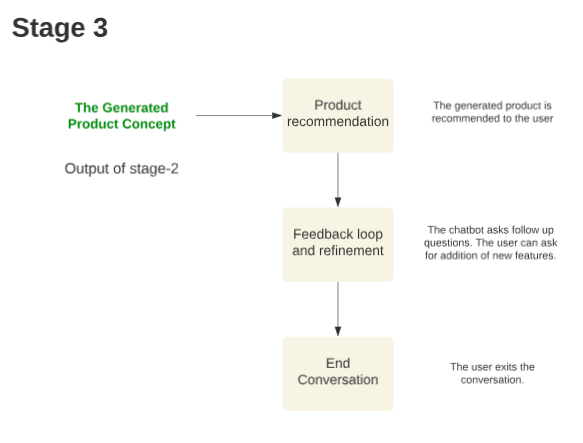

####**ask_follow_up_questions():**
This function generates a follow-up conversation about a product. It constructs a prompt to simulate a product recommender engaging with a user by asking relevant questions. If no product is provided in the input string, the function outputs an empty string.

In [14]:
def ask_follow_up_questions(product):
    prompt = f"""
    You are an expert product recommender, you already have a generated product.
    You are required to converse with the user by asking relevant questions naturally like,
    ###
    example 1:
    I hope you are satisfied with this product
    Would you like to add any additional features?.
    ###

    ###
    Thought 1:
    End the conversation after providing the new product.
    ###

    ###
    Thought 2:
    When there is no generated product in the provided string. Ouput an empty string.
    ###
    """

    response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[{"role":"system", "content":product},
                  {"role":"assistant","content":prompt}],
        temperature = 0.4,
        max_tokens=100
    )
    return response.choices[0].message.content.strip()

####**handle_user_inputs():**
This function handles user interaction for customizing a product based on initial requirements. It asks follow-up questions to determine if additional features are needed and updates the product concept accordingly. The function also checks for inappropriate responses and provides a way for users to restart or conclude the conversation.

In [15]:
def handle_user_input(product_dict,product_description):
    fields = product_dict['Fields']
    products = product_dict['Products']
    features = product_dict['Features']
    # Ask follow-up questions
    follow_up_question = ask_follow_up_questions(product_description)
    print(follow_up_question)
    follow_up_response = input()
    moderation = moderation_check(follow_up_response)
    # print("User:", follow_up_response)

    while (follow_up_response.lower() == 'no'):
      if moderation == 'Flagged':
        display("Sorry, this message has been flagged. Please restart your conversation.")
        break
      else:
        print("Thank you! Please visit again")
        user_input = input()
        return user_input
        break

    # Check if user wants to add more features
    if 'yes' in follow_up_response.lower():
       new_features = input("Please specify the additional feature(s) : \n Please enter the features seperated with a comma(,) :").split(',')
       features.extend(new_features)

       print("\nPlease wait while I get the product\n")

       New_user_requirements = {'Fields':fields,'Products': products,'Features':features}

       # Generate updated product with new features
       updated_product_concept = generate_product_concept(New_user_requirements, Products)
       print(updated_product_concept)
       user_input = input()
       return user_input


# # Example user inputs
# response_assistant = {'Fields': ["Healthcare", "Technology"],
#      'Products': ["smartwatch", "fitness tracker"],
#      'Features': ["GPS", "music capabilities", "heart rate monitoring", "waterproof", "sleep tracking", "calorie tracking"]
#  }

# # Handle user input and process
# handle_user_input(response_assistant, product_concept)


####**dialogue_management():**
This function manages a conversational system between a user and the chatbot assistant, initializing the conversation, handling user input, performing moderation checks, and managing the recommendation process based on user interactions. It retrieves and confirms the user's intent, generates a product concept based on the conversation, and presents the recommended product to the user. If any message is flagged during moderation checks, the conversation is halted, and the user is prompted to restart.

In [16]:
def dialogue_management():
  """
    Manages a conversational system between a user and an assistant to recommend the generated product.

    This function initializes the conversation, retrieves the introduction, handles user input,
    performs moderation checks, and manages the recommendation process based on user interactions.

    Returns:
        None
    """

  conversation = initialize_conversation()

  introduction = get_chat_completions(conversation)

  print(introduction + '\n')

  response_dict = None

  user_input = ''
  product = None

  while(user_input != "exit"):

        user_input = input()

        moderation = moderation_check(user_input)
        if moderation == 'Flagged':
            display("Sorry, this message has been flagged. Please restart your conversation.")
            break

        if response_dict is None:

            conversation.append({"role": "user", "content": user_input})

            response_assistant = get_chat_completions(conversation)
            moderation = moderation_check(response_assistant)
            if moderation == 'Flagged':
                display("Sorry, this message has been flagged. Please restart your conversation.")
                break

            confirmation = intent_confirmation_layer(response_assistant)

            # print("Intent Confirmation Yes/No:",confirmation.get('result'))

            if "No" in confirmation.get('result'):
                conversation.append({"role": "assistant", "content": str(response_assistant)})
                print("\n" + str(response_assistant) + "\n")

            else:
                # print("\n" + str(response_assistant) + "\n")
                # print('\n' + "Variables extracted!" + '\n')

                response_dict = dictionary_present(response_assistant)

                print("Thank you for providing all the information. Kindly wait, while I generate the product: \n")
                product = generate_product_concept(response_dict, Products)

                print(str(product) + '\n')

        else:
             moderation = moderation_check(user_input)
             if moderation == 'Flagged':
               display("Sorry, this message has been flagged. Please restart your conversation.")
               break

             rec_product= generate_product_concept(response_dict,Products)

             product = generate_product_concept(response_dict, Products)

             print(str(product) + '\n')

        if product:
          handle_user_input(response_dict, product)
          break



# **Chatbot Evaluation**

Evaluating the performance of the chatbot


#####**Test Case 1:**
The assistant confirmes user requirements and attempted to generate the product but faced limitations in providing specific product recommendations.


*The **test case failed** because the chatbot failed by generating wrong message even when the products were present in the dataset.*

In [ ]:
dialogue_management()

Welcome to GetIdea! How can I assist you today?

Hi! I'm Ria

Hello Ria! Welcome to GetIdea. How can I assist you today?

I'm looking for a product that combines both smartwatch and glasses

That's an interesting combination, Ria! Are you looking for a product that merges the features of a smartwatch and glasses into a single innovative device?

I would like music capabilities and protective lenses

Great choice, Ria! So, you're looking for a product that combines the features of a smartwatch and glasses, with music capabilities and protective lenses. Are there any additional features you would like this product to have?

Yes, I would like calling capabilities as well

Got it, Ria! So, you're looking for a product that combines the features of a smartwatch and glasses, with music capabilities, protective lenses, and calling capabilities. Is there anything else you would like to add to this innovative product?

No, that's all
Thank you for providing all the information. Kindly wait, whi

#####**Test Case 2:**

The assistant confirmes user requirements and sucessfully generated the product and also asked follow up questions. The assistant also added a new feature asked by the user at last and generated a new product with all the final requirements.

*The ***Test Case Passed*** as the chatbot performed very well in this case*

In [ ]:
dialogue_management()

Welcome to GetIdea! How can I assist you today?

Hi! I'm Nithin. I'm an Entrepreneur

Hello Nithin! Welcome to GetIdea. How can I assist you today?

I'm looking for an innovative product.

Great! To help you find an innovative product, could you please provide me with some details about the specific field or industry you are interested in? This will help me suggest a product that aligns with your entrepreneurial goals.

I would like to integrate mirror with smartphone

That's an interesting concept! To combine a mirror with a smartphone, we could consider products from the 'Technology' and 'Home Decor' fields. Would you like the integrated product to have specific features or functionalities? This will help us narrow down the options and create a unique and innovative product for you.

I would like touchscreen and reflective surface
Thank you for providing all the information. Kindly wait, while I generate the product: 

Here is your Product!

Product Name: ReflectTech Connect
Product 

#####**Test Case 3:**

The assistant confirmes user requirements and sucessfully generated the product by combining the products present in the dataset and also asked follow up questions and ended the conversation successfully

*In this case, the user asked for a combination that included a product, whose detail was not available in the dataset. The assistant should generate an apology message for the unavailable product information and output the product concept for the other matched products.*

*The ***Test Case Passed*** as the chatbot performed very well in this case.*

In [ ]:
dialogue_management()

Welcome to GetIdea! How can I assist you today?

I'm Jeevan

Hello Jeevan! Welcome to GetIdea. How can I assist you today?

I would like to combine a boll with fitness tracker and smartphone

Great choice, Jeevan! To combine a ball with a fitness tracker and smartphone, we can consider integrating features like tracking physical activity, receiving notifications, and possibly incorporating smart functionalities into the ball itself. 

Do you have any specific features in mind that you would like to include in this innovative product?

A curve surface, touchscreen and heart rate monitoring

Fantastic! By combining a ball with a curved surface, touchscreen capabilities, and heart rate monitoring, we can create a unique and interactive fitness experience. 

Would you like to add any additional features or functionalities to this innovative product?

No! that's all

Got it, Jeevan! To summarize, you're looking to create a ball with a curved surface, touchscreen capabilities, and heart rate

#####**Test Case 4:**

The assistant accepts user requirements and sucessfully generated an apology message since the product information was not available in the dataset i.e., there were no matched_products.

*In this case, the user asked for a combination that included products, whose information was not available in the dataset. The assistant should generate an apology message for the unavailable product information.*

*The ***Test Case Passed*** as the chatbot performed very well in this case.*

In [123]:
dialogue_management()

Welcome to GetIdea! How can I assist you today?

Hi! I'm Trisha

Hello Trisha! Welcome to GetIdea. How can I assist you today?

I want a product combination of smartoven and telephone

Great choice, Trisha! To create a unique product combining a smart oven and a telephone, we can consider integrating features like remote control for the oven, voice commands for cooking instructions, and perhaps a built-in screen for video calls while cooking. 

Would you like to add any specific features or functionalities to this product combination?

Voice commands and video calls

Fantastic! So, for the product combination of a smart oven and a telephone, we will include features such as remote control for the oven, voice commands for cooking instructions, and a built-in screen for video calls. 

Is there any other feature you would like to add to this innovative product?

No! that's all
Thank you for providing all the information. Kindly wait, while I generate the product: 

My apologies! I do not 

#####**Test Case 5:**

A Random test.
All the products the user asked are matched products.

*The ***Test Case Passed*** as the chatbot performed very well in this case.*

In [17]:
dialogue_management()


Welcome to GetIdea! How can I assist you today?

Hi! I'm Bhumi

Hello Bhumi! Welcome to GetIdea. How can I assist you today?

I'm looking for a product that combines a door lock with smartphone

Great choice! To better understand your requirements, could you please specify if you have any particular features in mind for this product that combines a door lock with a smartphone?

I would like it to be durable and to have touchscreen functionality

Got it! For a product that combines a door lock with smartphone capabilities, with a focus on durability and touchscreen functionality, would you also be interested in features like remote access or keyless entry?

I would like keyless entry

Fantastic choice! A product that combines a door lock with smartphone capabilities, emphasizing durability, touchscreen functionality, and keyless entry, sounds like a great innovation. Would you like any additional features such as security notifications or integration with smart home systems?

I would to